**The core notebooks for this project are:**

*   01_eda_data_cleaning.ipynb
*   02_baseline_models.ipynb
*   03_transformers.ipynb
*  streamlit_prototype.ipynb

**Notebook 03 - Transformer Models**

This notebook trains and evaluates transformer-based models (BERT and RoBERTa) for multi-label emotion classification. Controlled experiments are conducted to compare model configurations and select the best-performing model based on validation performance. Emotion-level probability outputs are then aggregated into valence-arousal quadrants for quadrant-level evaluation.

During model selection, only evaluation metrics, logits, decision thresholds, and configuration parameters are retained, while trained model instances are discarded. The selected configuration is therefore retrained to produce a final model for inference in interpretability analysis, and prototype deployment, and is saved for consistent downstream use.

In [1]:
#project paths:
#project root: /content/drive/MyDrive/applied_research_project/
#cleaned data directory: /content/drive/MyDrive/applied_research_project/data
#prototype directory: /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype
#best model storage path: /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype/best_emo_model

In [2]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Import Libraries

In [3]:
#main python and data handling libraries
import numpy as np
import pandas as pd
import os

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning & evaluation metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

#transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import(AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding)
from transformers import EarlyStoppingCallback
from typing import List, Dict, Optional

import joblib
import sys

#add project root to Python path to import utils.py
sys.path.append('/content/drive/MyDrive/applied_research_project')
import utils

# 2.Loading Data

This section loads the preprocessed text inputs for transformers and targets from Notebook 01 and retrieves the official GoEmotions emotions list.

In [4]:
#directory containing preprocessed features and labels
data_dir = "/content/drive/MyDrive/applied_research_project/data"

#load cleaned text inputs for transformers
X_train_transformer = joblib.load(f"{data_dir}/X_train_transformer.pkl")
X_val_transformer   = joblib.load(f"{data_dir}/X_val_transformer.pkl")
X_test_transformer  = joblib.load(f"{data_dir}/X_test_transformer.pkl")

#load emotion targets
y_train = joblib.load(f"{data_dir}/y_train.pkl")
y_val   = joblib.load(f"{data_dir}/y_val.pkl")
y_test  = joblib.load(f"{data_dir}/y_test.pkl")

In [5]:
#load the GoEmotions emotion list from the official Google Research Repository
emotions_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/emotions.txt'
emotions=pd.read_csv(emotions_url,header=None)

label_names=emotions[0].tolist()

#initialise label binarizer and fix emotion class order for consistency across models
mlb = MultiLabelBinarizer()
mlb.classes_ = emotions.iloc[:, 0].values

# 3.Transformer-Based Emotion Classification Models (BERT, RoBERTa)

In [6]:
!pip -q install torch transformers==4.44.2 accelerate scikit-learn evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.2 MB/s eta 0:00:00


In [7]:
import evaluate
import itertools, math, random, gc, time, traceback

## 3.1.Seed Setting for Reproducibility and Device Configuration

A fixed random seed is set to ensure reproducible model initialisation, data handling, training behaviour, and evaluation results across runs.

In [8]:
#ensure reproducibility across Python, NumPy, and PyTorch
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #select gpu if available else use cpu

## 3.2.Dataset Class for Transformers

In [9]:
#custom PyTorch dataset for multi-label emotion classification

class EmoDataset(Dataset):
  def __init__(self, texts, y, tok, max_len=80):
    self.texts=texts
    self.y=torch.tensor(y, dtype=torch.float32)
    self.tok=tok
    self.max_len=max_len

  #get the total num of texts in the dataset
  def __len__(self): return len(self.texts)

  def __getitem__(self, i):

    #tokenize one sentence at a time
    enc=self.tok(self.texts[i], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")

    #remove batch dimension added by the tokenizer
    item={k: v.squeeze(0) for k, v in enc.items()}

    #attach the corresponding multi-label target
    item["labels"]=self.y[i]
    return item

## 3.3.Loss Functions

In [10]:
#Asymmetric Loss (ASL) class
class AsymmetricLossClipped(nn.Module):

  def __init__(self, gamma_pos=1.0, gamma_neg=3, eps=0.04):
    super().__init__()
    self.gamma_pos=gamma_pos
    self.gamma_neg=gamma_neg
    self.eps=eps

  def forward(self, logits, y_true):
    #convert logits to probabilities using sigmoid
    y_hat=torch.sigmoid(logits)

    if self.eps>0:
      y_hat=y_hat.clamp(min=self.eps, max=1.0-self.eps) #clip to eps, (1-eps)

    #positive and negative sample losses
    pos_loss=-(y_true)*torch.log(y_hat)*torch.pow(1.0-y_hat, self.gamma_pos)
    neg_loss=-(1.0-y_true)*torch.log(1.0-y_hat)*torch.pow(y_hat, self.gamma_neg)

    #combine positive and negative losses and average across the batch
    loss=pos_loss+neg_loss
    return loss.sum()/logits.size(0)

#select and configure loss function
def get_criterion(loss, y_train, gamma_pos=1.0, gamma_neg=3, eps=0.04):

  #Asymmetric Loss
  if loss.lower()=="asl":
    return AsymmetricLossClipped(gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #Weighted Binary Cross-Entropy
  elif loss.lower()=="wbce":

    #count positive and negative occurrences per label
    pos_counts=y_train.sum(axis=0)+1e-6
    neg_counts=(y_train.shape[0]-pos_counts)+1e-6

    #assign higher weight to rarer positive labels
    pos_weight=torch.tensor(neg_counts/pos_counts, dtype=torch.float32).to(device)
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  else:
    raise ValueError(f"Unknown loss: {loss}")

## 3.4. Training and Evaluation Workflow

This section implements a three-stage training workflow comprising: single-configuration fine-tuning, structured hyperparameter configuration, and experimental execution to identify the best-performing transformer model.

### 3.4.1. Single Configuration Training Runner

In [11]:
#runs one complete experiment: train, threshold tuning, and test evaluation for a given configuration

#apply sigmoid and per-label thresholds
def apply_thresholds(logits, thresholds):
  probs=1/(1+np.exp(-logits))
  preds=(probs >= thresholds).astype(int)
  return preds, probs

def run_one_config(cfg):

  #extract hyperparameters for the current configuration
  model_name=cfg["model_name"]
  max_len=int(cfg["max_len"])
  batch_size=int(cfg["batch_size"])
  lr=float(cfg["lr"])
  epochs=int(cfg["epochs"])
  loss=cfg["loss"]
  gamma_pos=float(cfg["gamma_pos"])
  gamma_neg=float(cfg["gamma_neg"])
  eps=float(cfg["eps"])
  warmup_ratio=float(cfg["warmup_ratio"])
  weight_decay=float(cfg["weight_decay"])

  #load tokenizer for the selected transformer model
  tokenizer=AutoTokenizer.from_pretrained(model_name)

  #construct train, val, and test datasets
  train_ds=EmoDataset(X_train_transformer, y_train, tokenizer, max_len=max_len)
  val_ds=EmoDataset(X_val_transformer, y_val, tokenizer, max_len=max_len)
  test_ds=EmoDataset(X_test_transformer, y_test, tokenizer, max_len=max_len)

  #dynamically pad batches to the longest sequence in each batch
  collator=DataCollatorWithPadding(tokenizer)

  #load transformer model
  model=AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=y_train.shape[1], problem_type="multi_label_classification").to(device)

  #initialise loss function
  criterion=get_criterion(loss, y_train, gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #custom loss computation to integrate the selected criterion with Trainer
  def compute_loss(model, inputs, return_outputs=False,**kwargs):
    labels=inputs.pop("labels") #remove 'labels' from inputs dictionary
    outputs=model(**inputs)     #feed the remaining inputs to the model
    logits=outputs.logits       #extract the logits from model outputs
    loss=criterion(logits, labels.to(logits.dtype))  #compute the loss between predicted logits and true labels
    return (loss, outputs) if return_outputs else loss

  #training configuration for the current run
  args=TrainingArguments(
    output_dir=f"./emo-{model_name.split('/')[0]}/{int(time.time())}",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=max(16, batch_size),
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    lr_scheduler_type="linear",
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=["none"],
    save_total_limit=2
  )

  #initialise Trainer with early stopping
  trainer=Trainer(
      model=model,
      args=args,
      train_dataset=train_ds,
      eval_dataset=val_ds,
      tokenizer=tokenizer,
      data_collator=collator,
      callbacks=[
          EarlyStoppingCallback(
              early_stopping_patience=2,
              early_stopping_threshold=0.0
          )
      ]
  )

  #use custom loss function during training
  trainer.compute_loss=compute_loss

  #train the model
  trainer.train()

  #run validation inference and tune per-label decision thresholds
  val_out = trainer.predict(val_ds)
  val_logits = val_out.predictions
  ts_label=utils.best_thresholds_per_label(val_logits, y_val, n_grid=80, use_quantiles=False, scores_are_logits=True)
  val_preds_perlabel_tuned, val_probs_perlabel_tuned=apply_thresholds(val_logits, ts_label)
  val_macro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="macro", zero_division=0)
  val_micro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="micro", zero_division=0)

  #compute validation performance using a fixed 0.5 threshold baseline
  baseline_ts=utils.baseline_thresholds(y_val)
  val_preds_baseline_ts, val_probs_baseline=apply_thresholds(val_logits, baseline_ts)
  val_macro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="macro", zero_division=0)
  val_micro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="micro", zero_division=0)

  #run test inference using thresholds tuned on the validation set
  test_out = trainer.predict(test_ds)
  test_logits = test_out.predictions

  #evaluate on test set using thresholds derived from validation data
  test_preds_perlabel_tuned, test_probs_perlabel_tuned=apply_thresholds(test_logits, ts_label)
  test_macro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="macro", zero_division=0)
  test_micro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="micro", zero_division=0)

  test_preds_baseline_ts, test_probs_baseline_ts=apply_thresholds(test_logits, baseline_ts)
  test_macro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="macro", zero_division=0)
  test_micro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="micro", zero_division=0)

  #aggregate evaluation metrics and configuration details for this run
  result={
    "val_macro":float(val_macro_perlabel_tuned),
    "val_micro":float(val_micro_perlabel_tuned),
    "test_macro":float(test_macro_perlabel_tuned),
    "test_micro":float(test_micro_perlabel_tuned),

    "val_macro_0.5_ts":float(val_macro_baseline_ts),
    "val_micro_0.5_ts":float(val_micro_baseline_ts),
    "test_macro_0.5_ts":float(test_macro_baseline_ts),
    "test_micro_0.5_ts":float(test_micro_baseline_ts),

    "thresholds":ts_label,
    "cfg": cfg
  }

  #convert model outputs to NumPy arrays
  def _to_numpy(x):
      if hasattr(x, "detach"):
          x = x.detach().cpu().numpy()
      return np.asarray(x)

  val_logits_np  = _to_numpy(val_out.predictions)
  test_logits_np = _to_numpy(test_out.predictions)

  #store logits in the result dictionary
  result.update({
      "val_logits":  val_logits_np,
      "test_logits": test_logits_np,

  })

  #release resources before the next run
  del trainer, model
  torch.cuda.empty_cache()
  gc.collect()
  return result

### 3.4.2.Transformers Configurations Grid and Search Helper

In [12]:
#define experiment configurations for grid search across BERT and RoBERTa

#full grid used for preliminary hyperparameter exploration and selection

#grid_bert={
#    "model_name": ["bert-base-uncased"],
#    "loss": ["asl", "wbce"],
#    "gamma_pos": [1.0],
#    "gamma_neg": [3.0],
#    "eps":[0.03],
#    "lr":[1e-5, 3e-5, 5e-5],
#    "batch_size":[32],
#    "epochs":[4, 5, 6],
#    "max_len":[128],
#    "warmup_ratio":[0.06],
#    "weight_decay":[0.01]
#}

#grid_roberta={
#    "model_name": ["roberta-base"],
#    "loss": ["asl", "wbce"],
#    "gamma_pos": [1.0],
#    "gamma_neg": [3.0],
#    "eps":[0.03],
#    "lr":[1e-5, 3e-5, 4e-5, 5e-5],
#    "batch_size":[32, 64],
#    "epochs":[4, 5, 6],
#    "max_len":[128, 256],
#    "warmup_ratio":[0.06],
#    "weight_decay":[0.01]
#}

#BERT Base Configuration
grid_bert={
    "model_name": ["bert-base-uncased"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[32],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#RoBERTa Base Configuration
grid_roberta={
    "model_name": ["roberta-base"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[64],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#generate all hyperparameter combinations
def dict_product(d):
  keys=list(d.keys())
  for values in itertools.product(*(d[k] for k in keys)):
    yield dict(zip(keys, values))

#generate configurations for each model
cfgs_bert=list(dict_product(grid_bert))
cfgs_roberta=list(dict_product(grid_roberta))

#combine model identifiers with their respective configurations
experiment_cfgs=[("bert-base-uncased", cfg) for cfg in cfgs_bert] + [("roberta-base", cfg) for cfg in cfgs_roberta]

### 3.4.3.Experimental Execution

In [13]:
#run grid search experiments, track the best configuration per model, and select overall best model based on val macro-F1

best_per_model={} #store best result per model
history=[]        #store results from all runs

#iterate over all experiment configurations
for i, (model_key, cfg) in enumerate(experiment_cfgs, 1):
    print(f"\n[{i}/{len(experiment_cfgs)}] Running {model_key} with cfg: {cfg}")
    try:
        set_seed(42)
        result=run_one_config(cfg)
        history.append(result)
        model_name= cfg["model_name"]

        #update best result for the current model based on val macro-F1
        if model_name not in best_per_model:
          best_per_model[model_name]=result
        else:
          if result["val_macro"] > best_per_model[model_name]["val_macro"]:
            best_per_model[model_name]=result
        print(f"{model_name}: Val macro-F1={result['val_macro']:.4f}, micro-F1={result['val_micro']:.4f}")

    #handle runtime errors
    except RuntimeError as e:
        msg = str(e)
        print("RuntimeError:", msg)
        if "CUDA out of memory" in msg:
            print("GPU Out of Memory")
        else:
            traceback.print_exc()

    except Exception as e:
        print("Exception:", e)
        traceback.print_exc()

    #release gpu memory after each run
    finally:
        torch.cuda.empty_cache(); gc.collect()

#report the best configuration per model
print("\nPer model best results\n")
for model_name, res in best_per_model.items():
  print("Model:", model_name)
  print("Best Configuration:", res['cfg'])
  print(f"Val  macro-F1 using per-label threshold {res['val_macro']:.4f} | micro-F1 {res['val_micro']:.4f}")
  print(f"Test macro-F1 using per-label threshold {res['test_macro']:.4f} | micro-F1 {res['test_micro']:.4f}")
  print(f"Val  macro-F1 using a fixed 0.5 threshold {res['val_macro_0.5_ts']:.4f} | micro-F1 {res['val_micro_0.5_ts']:.4f}")
  print(f"Test macro-F1 using a fixed 0.5 threshold {res['test_macro_0.5_ts']:.4f} | micro-F1 {res['test_micro_0.5_ts']:.4f}")
  print("_"*70)

#select and report the overall best configuration across all models
overall_best=max(best_per_model.values(), key=lambda r: r["val_macro"])
print("\nOverall best model\n")
print("Best cfg:", overall_best['cfg'])
print(f"Val  macro-F1 using per-label threshold {overall_best['val_macro']:.4f} | micro-F1 {overall_best['val_micro']:.4f}")
print(f"Test macro-F1 using per-label threshold  {overall_best['test_macro']:.4f} | micro-F1 {overall_best['test_micro']:.4f}")
print(f"Val  macro-F1 using a fixed 0.5 threshold {overall_best['val_macro_0.5_ts']:.4f} | micro-F1 {overall_best['val_micro_0.5_ts']:.4f}")
print(f"Test macro-F1 using a fixed 0.5 threshold {overall_best['test_macro_0.5_ts']:.4f} | micro-F1 {overall_best['test_micro_0.5_ts']:.4f}")


[1/2] Running bert-base-uncased with cfg: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3305792252.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.655200,0.631514
2,0.563200,0.626366
3,0.426600,0.693028
4,0.330400,0.783040


bert-base-uncased: Val macro-F1=0.5581, micro-F1=0.6173

[2/2] Running roberta-base with cfg: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3305792252.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.680600,0.645767
2,0.593500,0.621932
3,0.523900,0.633436
4,0.456600,0.659352


roberta-base: Val macro-F1=0.5516, micro-F1=0.6153

Per model best results

Model: bert-base-uncased
Best Configuration: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 using per-label threshold 0.5581 | micro-F1 0.6173
Test macro-F1 using per-label threshold 0.5279 | micro-F1 0.6014
Val  macro-F1 using a fixed 0.5 threshold 0.5076 | micro-F1 0.6166
Test macro-F1 using a fixed 0.5 threshold 0.5097 | micro-F1 0.6145
______________________________________________________________________
Model: roberta-base
Best Configuration: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 using per-label threshold 0.5516 | micro-F1 0.6153
Test macro-F1 using per-label thresh

## 3.5.Quadrant-Level Evaluation

In [14]:
#convert best model logits to probabilities using sigmoid
val_probs_emo=1/(1+np.exp(-overall_best["val_logits"]))
test_probs_emo=1/(1+np.exp(-overall_best["test_logits"]))

#build emotion-to-category mappings for category-level aggregation
emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert emotion-level labels to category-level labels
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

In [15]:
#convert emotion-level probabilities to category-level probabilities using noisy-or aggregation
val_scores_cat = utils.probs_emo_to_cat(val_probs_emo, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat = utils.probs_emo_to_cat(test_probs_emo, categories, cat_to_emoIds, mode="noisy_or")

#compute per-label thresholds for each category using val data
ts_cat=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

#compute fixed baseline thresholds 0.5
ts_baseline=utils.baseline_thresholds(y_val_cat)

#retrieve the best performing transformer name
best_model_name=overall_best["cfg"]["model_name"]

#evaluate category-level model performance on val and test splits
print(f"\nBest Transformer: ({best_model_name})\nCategory-Level Evaluation - Val Split\n")
val_metrics=utils.evaluate_run(y_val_cat, val_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_scores_cat, ts_baseline, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation\nFixed 0.5 Threshold\n")

print("\nCategory-Level Evaluation - Test Split\n")
test_metrics=utils.evaluate_run(y_test_cat, test_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
utils.evaluate_run(y_test_cat, test_scores_cat, ts_baseline, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation\nFixed 0.5 Threshold\n")


Best Transformer: (bert-base-uncased)
Category-Level Evaluation - Val Split


Best Transformer (Val Split): Quadrant-Level Evaluation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.74
Macro F1: 0.72

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.68      0.86      0.76      2341
    pleasant_active       0.72      0.83      0.77      1623
  pleasant_deactive       0.83      0.72      0.77       702
  unpleasant_active       0.60      0.71      0.65       891
unpleasant_deactive       0.67      0.60      0.63       389

          micro avg       0.69      0.80      0.74      5946
          macro avg       0.70      0.75      0.72      5946
       weighted avg       0.69      0.80      0.74      5946
        samples avg       0.74      0.82      0.75      5946


Best Transformer (Val Split): Quadrant-Level Evaluation
Fixed 0.5 Threshold

Micro F1: 0.44
Macro F1: 0.41

Detailed Classification Report:


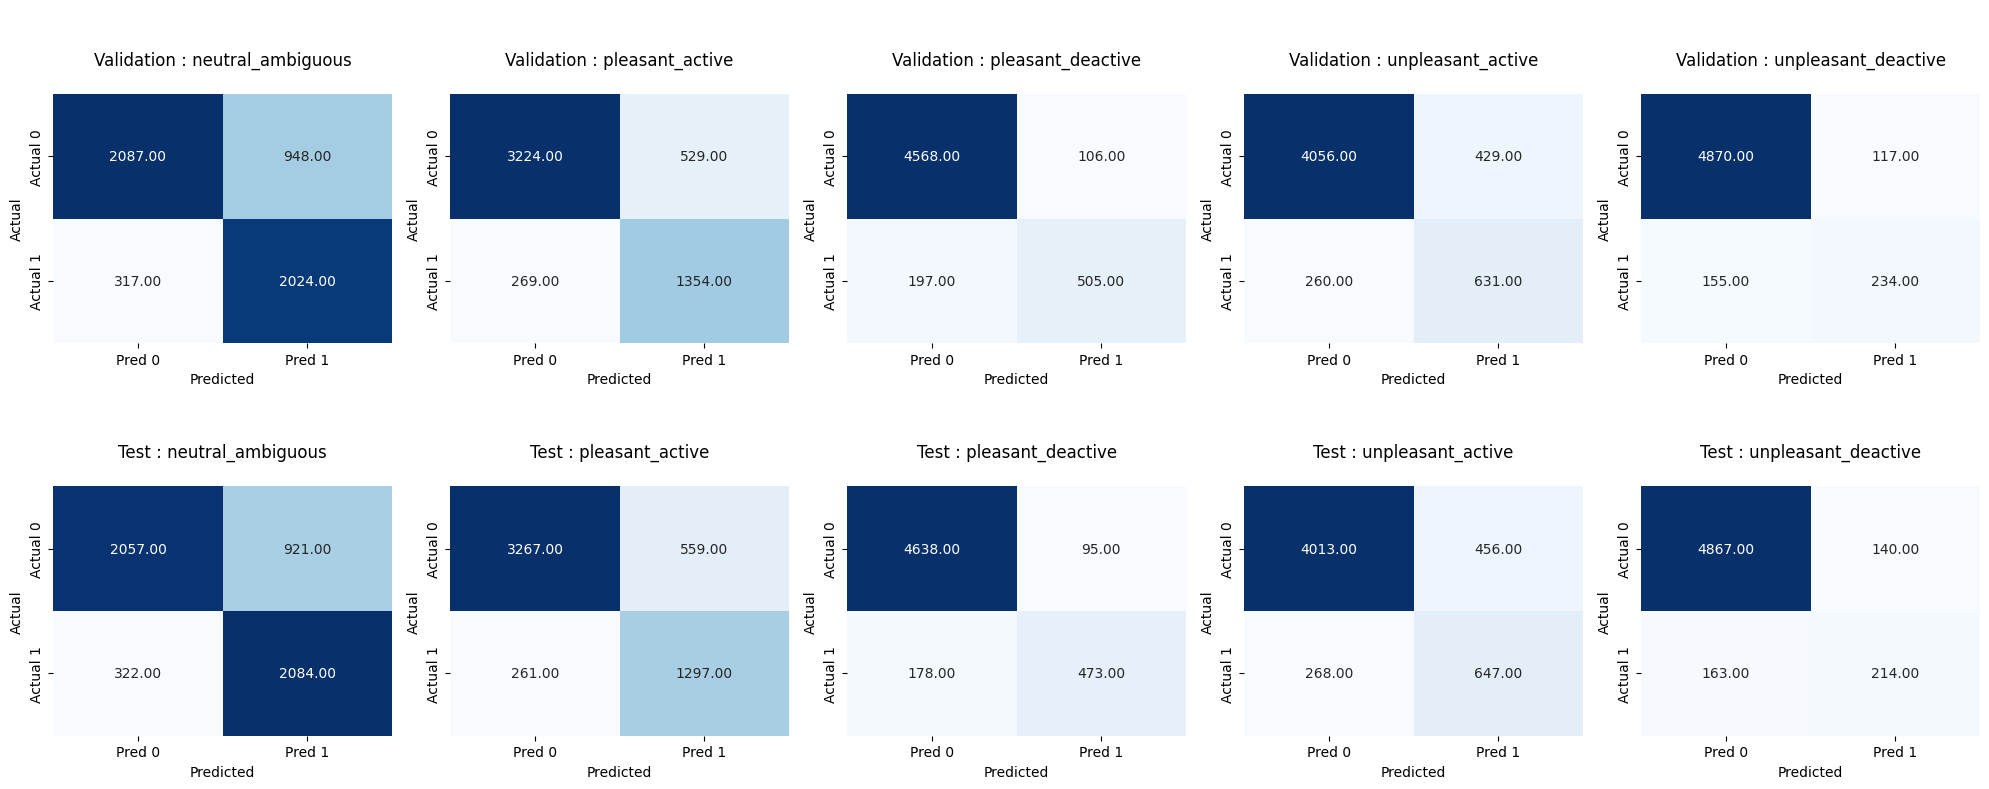

In [16]:
#compute per-quadrant confusion matrices for val and test splits
cm_val_transformer=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_cat, categories)

cm_test_transformer=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_cat, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_transformer, cm_test_transformer, categories, normalize=False)

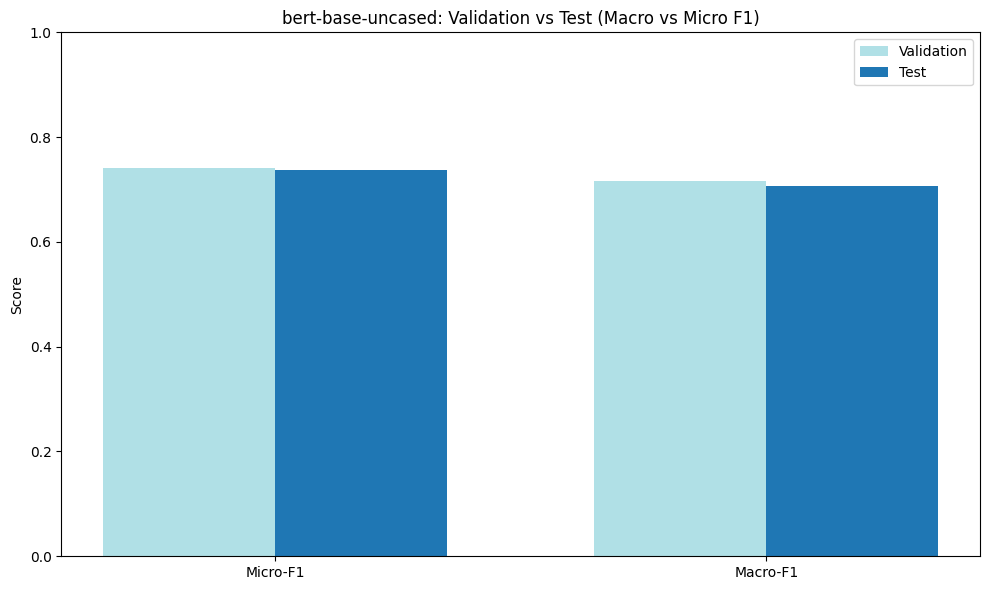

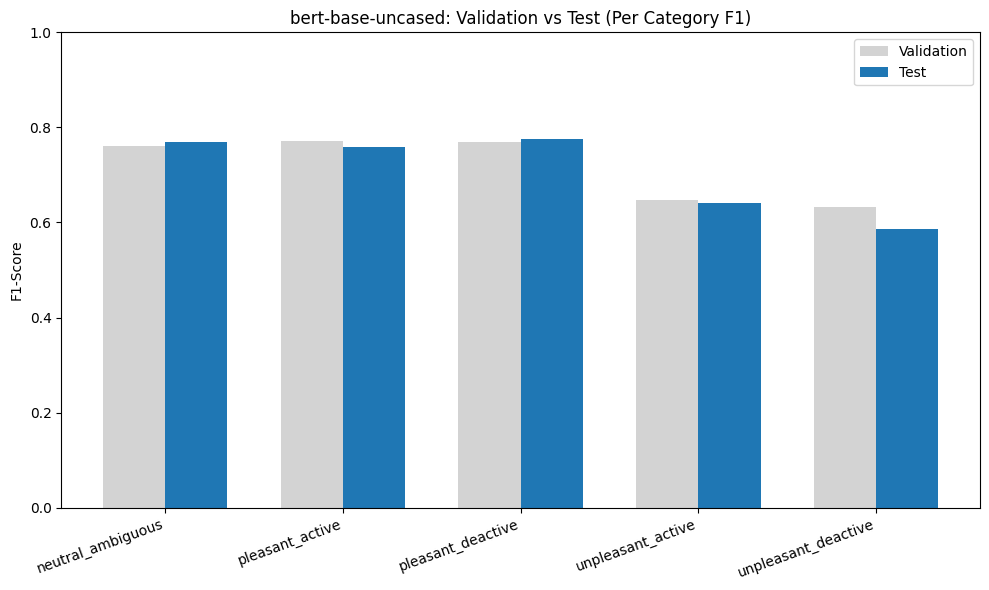

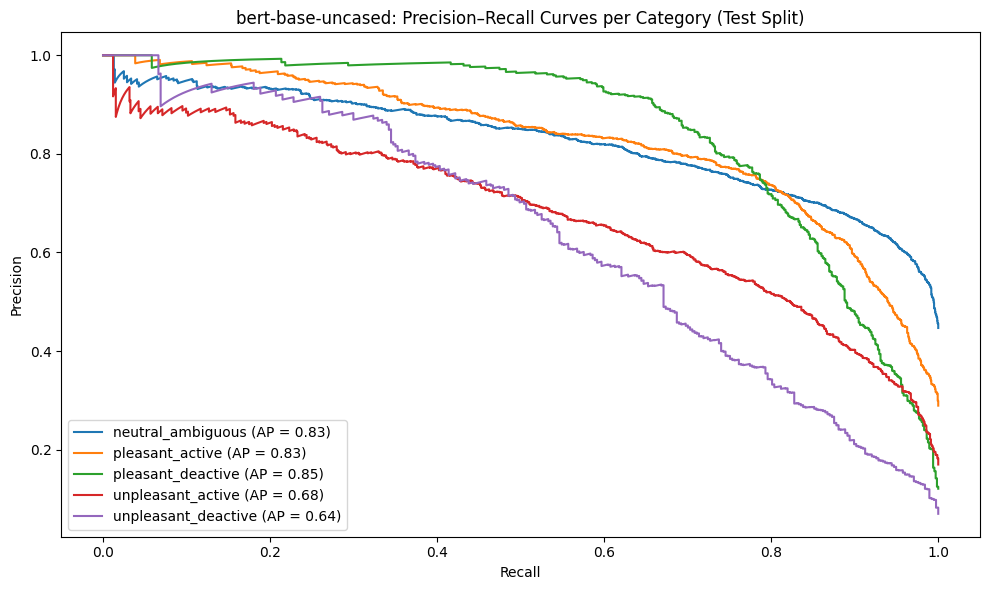

In [17]:
#compare val and test Micro-F1 and Macro-F1 scores for the selected best model
utils.plot_val_test_macro_micro(val_metrics, test_metrics, model_name=overall_best["cfg"]["model_name"])

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics, test_metrics, categories, model_name=overall_best["cfg"]["model_name"])

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name=overall_best["cfg"]["model_name"])

# 4.Mapping Burnout Indicators from Predicted Quadrants

In [18]:
#determine a burnout-related indicator from quadrant-level predictions using rule-based priority scheme

def burnout_indicator_from_quadrants(pred_row, col_idx):

  #extract binary predictions for each affective quadrant
  NEU=int((pred_row[col_idx["neutral_ambiguous"]]))
  PA=int((pred_row[col_idx["pleasant_active"]]))
  PD=int((pred_row[col_idx["pleasant_deactive"]]))
  NA=int((pred_row[col_idx["unpleasant_active"]]))
  ND=int((pred_row[col_idx["unpleasant_deactive"]]))

  #assign a burnout-related indicator using a rule-based priority
  if ND:
    return "Signs of Advanced Burnout (Exhaustion/Ineffectiveness)"
  elif NA:
    return "Signs of Moderate Burnout (Stress/Cynicism)"
  elif PA:
    return "Indicators of Engagement (No Apparent Signs of Burnout)"
  elif PD:
    return "Indicators of Satisfaction (No Apparent Signs of Burnout)"
  elif NEU:
    return "Ambiguous Burnout Indicator"
  else:
    return "Ambiguous Burnout Indicator"

In [19]:
#convert category probabilities to binary predictions using per-label thresholds
preds_cat = (test_scores_cat >= ts_cat).astype(int)

#map quadrant names to their corresponding column indices
col_idx = {c:i for i,c in enumerate(categories)}

#generate burnout-related indicator for each test
labels = [burnout_indicator_from_quadrants(row, col_idx) for row in preds_cat]

In [20]:
#summarise distribution of burnout-related indicators across the test set
pd.Series(labels).value_counts()

,count
Ambiguous Burnout Indicator,1878
Indicators of Engagement (No Apparent Signs of Burnout),1765
Signs of Moderate Burnout (Stress/Cynicism),1023
Indicators of Satisfaction (No Apparent Signs of Burnout),364
Signs of Advanced Burnout (Exhaustion/Ineffectiveness),354


# 5.Final Model Preparation


## 5.1.Final Retraining of the Selected Transformer

Following model selection, the best-performing configuration is retrained once to produce a consolidated model for interpretability analysis and prototype deployment.

In [21]:
#final retraining of the selected best-performing transformer for use in interpretability analysis and prototype

#retrieve the configuration corresponding to the best-performing model
best_cfg=overall_best["cfg"]
best_model_name=best_cfg["model_name"]

#load the corresponding tokenizer
tokenizer=AutoTokenizer.from_pretrained(best_model_name)

#extract training hyperparameters from the selected configuration
max_len=int(best_cfg["max_len"])
batch_size=int(best_cfg["batch_size"])
lr=float(best_cfg["lr"])
epochs=int(best_cfg["epochs"])
loss=best_cfg["loss"]
gamma_pos=float(best_cfg["gamma_pos"])
gamma_neg=float(best_cfg["gamma_neg"])
eps=float(best_cfg["eps"])
warmup_ratio=float(best_cfg["warmup_ratio"])
weight_decay=float(best_cfg["weight_decay"])

#construct dataset objects for train, val, and test splits
train_ds=EmoDataset(X_train_transformer, y_train, tokenizer, max_len=max_len)
val_ds=EmoDataset(X_val_transformer, y_val, tokenizer, max_len=max_len)
test_ds=EmoDataset(X_test_transformer, y_test, tokenizer, max_len=max_len)

#initialise a dynamic padding collator
collator=DataCollatorWithPadding(tokenizer)

#load instance of the selected transformer model
model_final=AutoModelForSequenceClassification.from_pretrained(
    best_model_name, num_labels=y_train.shape[1], problem_type="multi_label_classification").to(device)

#initialise the selected custom multi-label loss function
criterion=get_criterion(loss, y_train, gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

#custom loss computation to integrate the selected criterion with Trainer
def compute_loss(model, inputs, return_outputs=False,**kwargs):
    labels=inputs.pop("labels")
    outputs=model(**inputs)
    logits=outputs.logits
    loss=criterion(logits, labels.to(logits.dtype))
    return (loss, outputs) if return_outputs else loss

#configure training arguments for final retraining
args_final=TrainingArguments(
    output_dir=f"./emo-{best_model_name.split('/')[0]}/{int(time.time())}",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=max(16, batch_size),
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    lr_scheduler_type="linear",
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=["none"],
    save_total_limit=1
)

#initialise the Trainer for final retraining
trainer_final=Trainer(
    model=model_final,
    args=args_final,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
)

#use custom loss function during training
trainer_final.compute_loss=compute_loss

#retrain the model on the train split using the final configuration
trainer_final.train()

#retrieve the final trained model and switch it to inference mode
model_final=trainer_final.model
model_final.eval()
print("Final retraining of the selected best-performing model completed and ready for saving")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2691143178.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final=Trainer(


Epoch,Training Loss,Validation Loss
1,0.653400,0.633451
2,0.563100,0.622815
3,0.420400,0.701613
4,0.329200,0.789421


Final retraining of the selected best-performing model completed and ready for saving


## 5.2.Probability-Based Inference Function Definition


In [22]:
#generate emotion-level probability predictions for input texts using final model in inference mode

def predicted_prob(texts):

  #ensure input is handled as a list of strings for batched tokenisation
  if isinstance(texts, str):
    texts=[texts]
  else:
    texts=list(texts)
  texts=[str(t) for t in texts]

  #tokenise input texts
  enc=tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len).to(device)

  #run model inference without gradient computation and convert logits to probabilities
  with torch.no_grad():
    out=model_final(**enc)
    logits=out.logits
    probs=torch.sigmoid(logits)

  return probs.cpu().numpy()

# 6.Interpretability and Error Analysis


## 6.1.Per-Sample Prediction Table Construction


In [23]:
#construct per-sample analysis table for interpretability and error analysis

#run inference on the test texts and convert probabilities to binary predictions
probs_test=predicted_prob(X_test_transformer)
y_true=np.array(y_test)
ts_label=utils.best_thresholds_per_label(overall_best["val_logits"], y_val, n_grid=80, use_quantiles=False, scores_are_logits=True)
y_pred=(probs_test>ts_label).astype(int)

#build per sample results dataframe
df_test=pd.DataFrame({
    "text": X_test_transformer,
    "y_true": list(y_true),
    "y_pred": list(y_pred),
    "y_prob": list(probs_test)
})

#flag exact match labels: true if all labels match exactly
df_test["exact_match"]=[
    np.array_equal(t,p) for t,p in zip(y_true, y_pred)
]

#count true and predicted labels
df_test["true_count"]=[int(np.sum(t)) for t in y_true]
df_test["pred_count"]=[int(np.sum(p)) for p in y_pred]

#highest predicted probability for each sample
df_test["max_prob"]=[float(np.max(probs)) for probs in probs_test]

## 6.2.Interpretability Sample Preparation

For interpretability analysis, five samples were selected to cover high-confidence correct and incorrect predictions, medium-confidence cases, low-confidence correct predictions, and complex multi-label instances, in order to examine model behaviour across diverse prediction scenarios.

In [24]:
#select representative samples for interpretability analysis, stratified by confidence levels, correctness, and label complexity

def select_samples_inter(
    df,
    num_high_conf_corr=1,
    num_high_conf_incorr=1,
    num_med_conf=1,
    num_low_conf_corr=1,
    num_complex_texts=1):

  #fixed random seed to ensure reproducibility of sampled instances
  rnd_seed=np.random.RandomState(42)
  selected_texts_inter=[]

  #high confidence (>= 0.8) and correct prediction
  high_conf_corr=df[(df["exact_match"]) & (df["max_prob"]>=0.8)]
  if len(high_conf_corr)>0:
    selected_texts_inter+=list(high_conf_corr.sample(
        n=min(num_high_conf_corr, len(high_conf_corr)), random_state=rnd_seed
    ).index)

  #high confidence (>= 0.8) but incorrect prediction
  high_conf_incorr=df[(~df["exact_match"]) & (df["max_prob"]>=0.8)]
  if len(high_conf_incorr)>0:
    selected_texts_inter+=list(high_conf_incorr.sample(
        n=min(num_high_conf_incorr, len(high_conf_incorr)), random_state=rnd_seed
    ).index)

  #medium confidence (50%-80%) and correct/ incorrect prediction
  med_conf=df[(df["max_prob"]>=0.5) & (df["max_prob"]<0.8)]
  if len(med_conf)>0:
    selected_texts_inter+=list(med_conf.sample(
        n=min(num_med_conf, len(med_conf)), random_state=rnd_seed
    ).index)

  #low confidence (<50%) but correct prediction
  low_conf_corr=df[((df["exact_match"])) & (df["max_prob"]<0.5)]
  if len(low_conf_corr)>0:
    selected_texts_inter+=list(low_conf_corr.sample(
        n=min(num_low_conf_corr, len(low_conf_corr)), random_state=rnd_seed
    ).index)

  #multi labeled text with true_count>2 or pred_count>2
  complex_texts=df[((df["true_count"]>2) | (df["pred_count"]>2))]
  if len(complex_texts)>0:
    selected_texts_inter+=list(complex_texts.sample(
        n=min(num_complex_texts, len(complex_texts)), random_state=rnd_seed
    ).index)

  #remove duplicate texts in selected texts
  selected_texts_inter=list(set(selected_texts_inter))
  return selected_texts_inter

In [25]:
#map a binary multi-label vector to its corresponding emotion label names
def vec_labels(vec, label_names):
  v=np.array(vec)
  return [label_names[i] for i in range(len(label_names)) if v[i]==1]

#categorise each prediction by confidence level and correctness
def tag_case(row):
  max_prob=row["max_prob"]
  exact_match=row["exact_match"]

  #high-confidence predictions (>=0.8)
  if exact_match and max_prob>=0.8:
    return "High-conf correct"
  if (not exact_match) and max_prob>=0.8:
    return "High-conf incorrect"

  #medium-confidence predictions (0.5-0.8)
  if exact_match and (max_prob>=0.5) and (max_prob<0.8):
    return "Med-conf correct"
  if (not exact_match) and (max_prob>=0.5) and (max_prob<0.8):
    return "Med-conf incorrect"

  #low-confidence predictions (<0.5)
  if exact_match and (max_prob<0.5):
    return "Low-conf correct"
  if (not exact_match) and (max_prob<0.5):
    return "Low-conf incorrect"
  return "Other"

In [26]:
#select 5 interpretability analysis samples from the test set
selected_indices_inter=select_samples_inter(df_test, 1, 1, 1, 1, 1)
selected_inter_df=df_test.loc[selected_indices_inter].copy()

#convert true and predicted binary vectors into readable labels
selected_inter_df["true_labels"]=selected_inter_df["y_true"].apply(lambda v: vec_labels(v, label_names))
selected_inter_df["pred_labels"]=selected_inter_df["y_pred"].apply(lambda v: vec_labels(v, label_names))

#assign each sample by its confidence-correctness category for reporting
selected_inter_df["case_type"] = selected_inter_df.apply(tag_case, axis=1)

#extract raw text inputs for SHAP explanation
text_list_for_shap = selected_inter_df["text"].tolist()

## 6.3.SHAP-Based Explanations

In [27]:
!pip install shap

In [28]:
#initialise SHAP for model interpretability
import shap
shap.initjs()

#create a text masker using the same tokenizer as the final model
masker=shap.maskers.Text(tokenizer)

#build shap explainer over the probability inference function
explainer_shap=shap.Explainer(predicted_prob, masker, output_names=label_names)

PartitionExplainer explainer: 6it [00:19,  3.86s/it]


Sample 0
Text: aye they buggin for no reason im just saying good job keep it up.
Case type: Med-conf incorrect
Max prob: 0.6881541609764099
True labels: ['admiration', 'gratitude', 'optimism']
Predicted labels: ['admiration']
Top 3 predicted emotions for this sample:
1. admiration: 0.6882
2. approval: 0.4076
3. neutral: 0.3923
SHAP explanation for rank 1. admiration: (p = 0.6882)


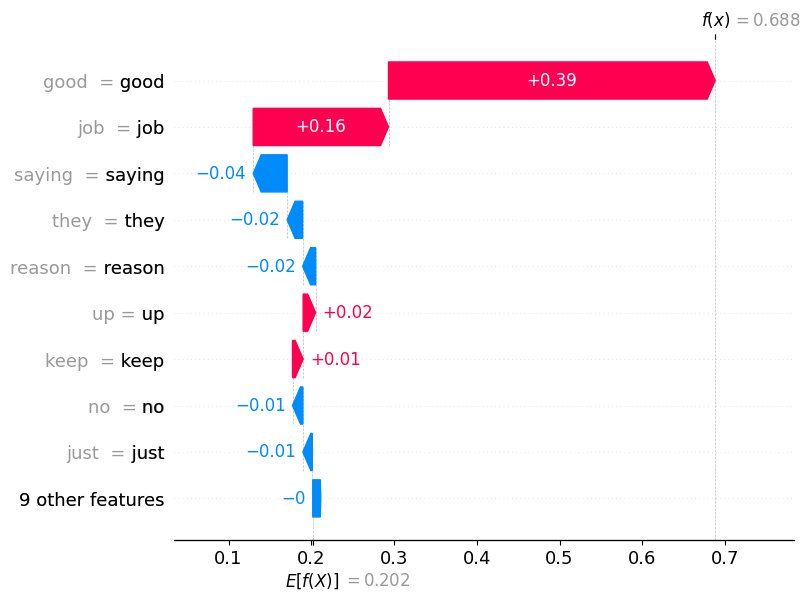

SHAP explanation for rank 2. approval: (p = 0.4076)


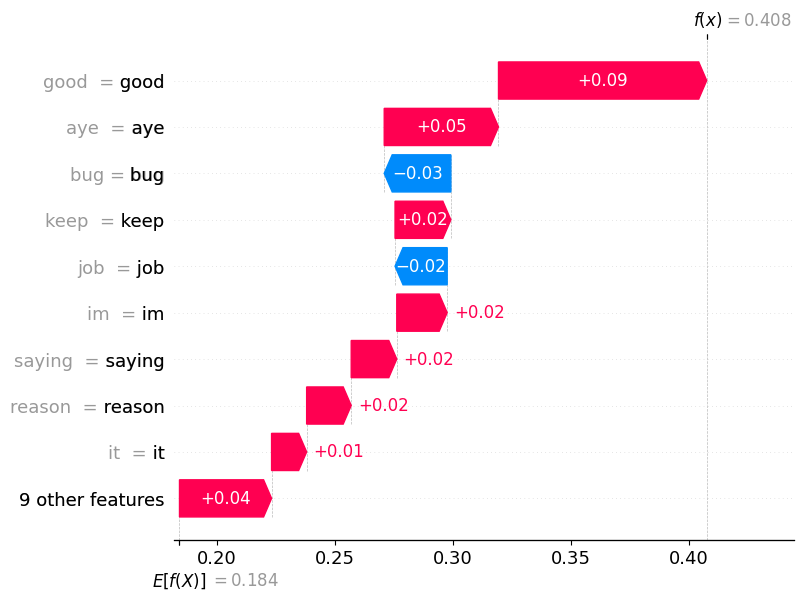

SHAP explanation for rank 3. neutral: (p = 0.3923)


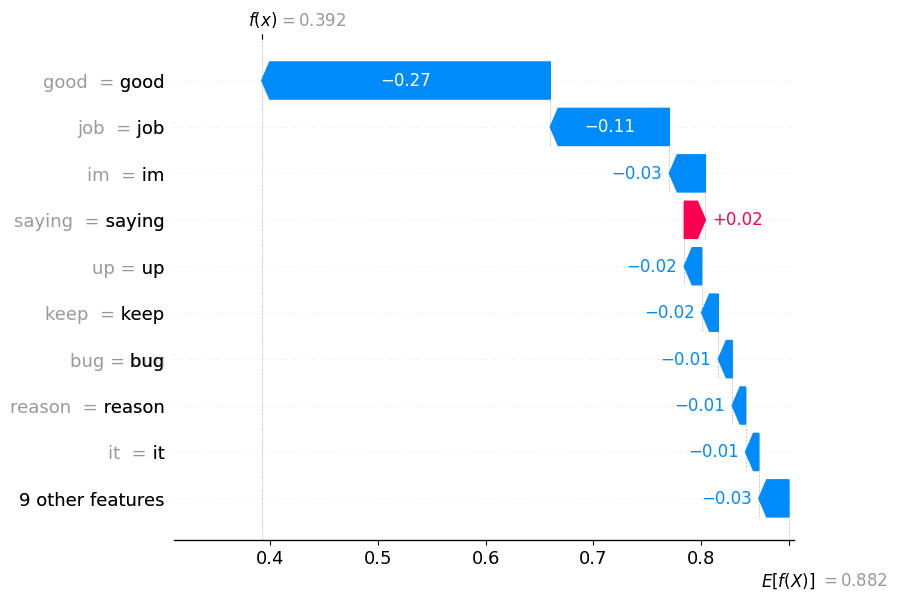

----------------------------------------------------------------------
Sample 1
Text: I agree. I was merely attacking the fragility and ineffectiveness of democracy. Thanks for the example!
Case type: High-conf incorrect
Max prob: 0.8944211602210999
True labels: ['gratitude']
Predicted labels: ['approval', 'gratitude']
Top 3 predicted emotions for this sample:
1. gratitude: 0.8944
2. approval: 0.7076
3. admiration: 0.2813
SHAP explanation for rank 1. gratitude: (p = 0.8944)


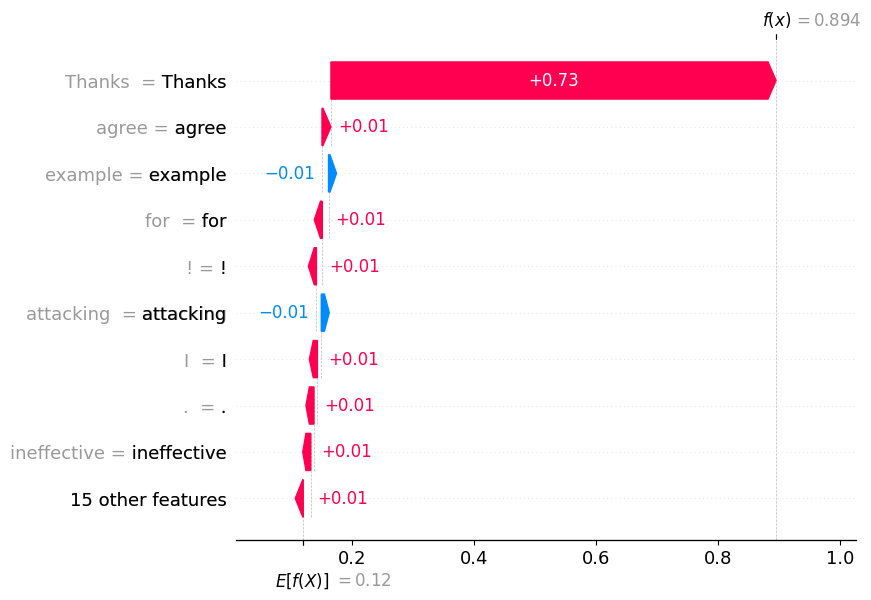

SHAP explanation for rank 2. approval: (p = 0.7076)


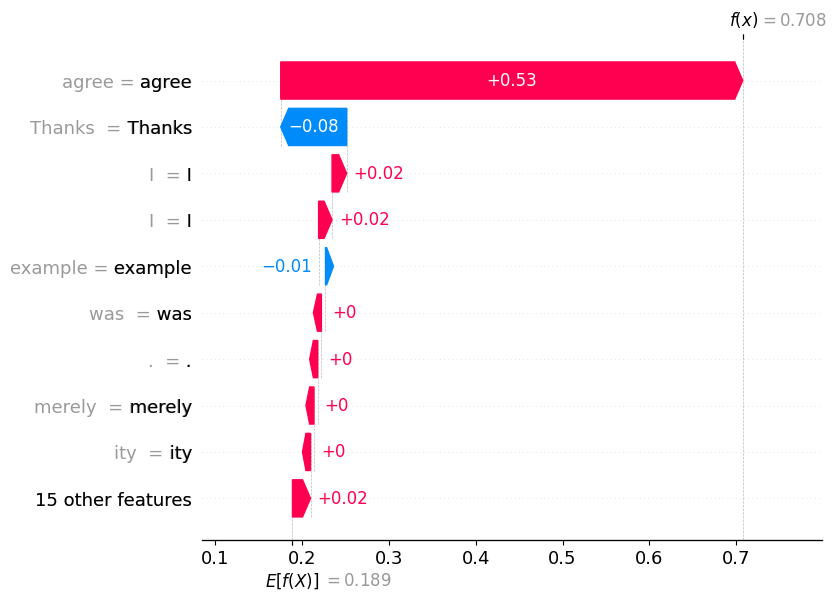

SHAP explanation for rank 3. admiration: (p = 0.2813)


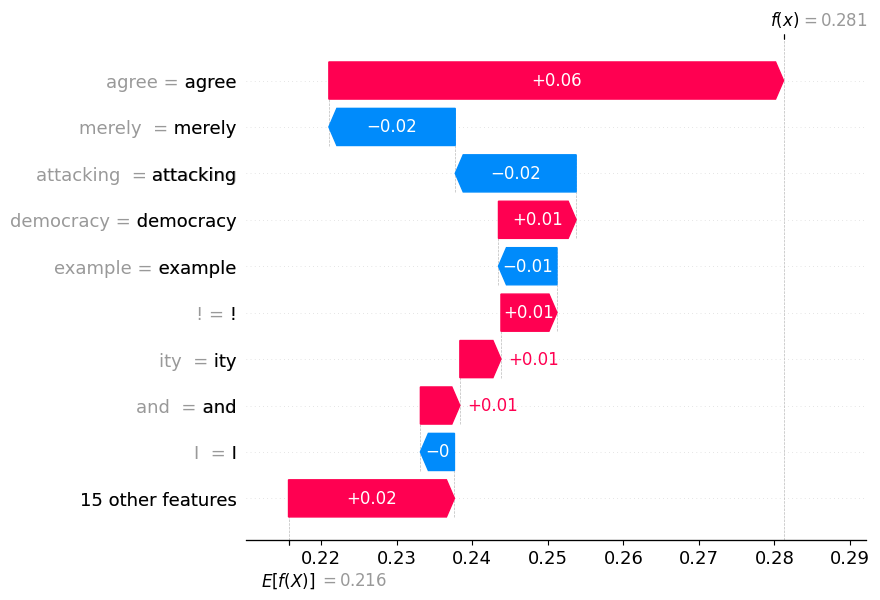

----------------------------------------------------------------------
Sample 2
Text: I mean yeah we were the best counter attacking team. That counter was so disappointing
Case type: Med-conf correct
Max prob: 0.658087968826294
True labels: ['disappointment']
Predicted labels: ['disappointment']
Top 3 predicted emotions for this sample:
1. disappointment: 0.6582
2. disapproval: 0.3968
3. admiration: 0.3952
SHAP explanation for rank 1. disappointment: (p = 0.6582)


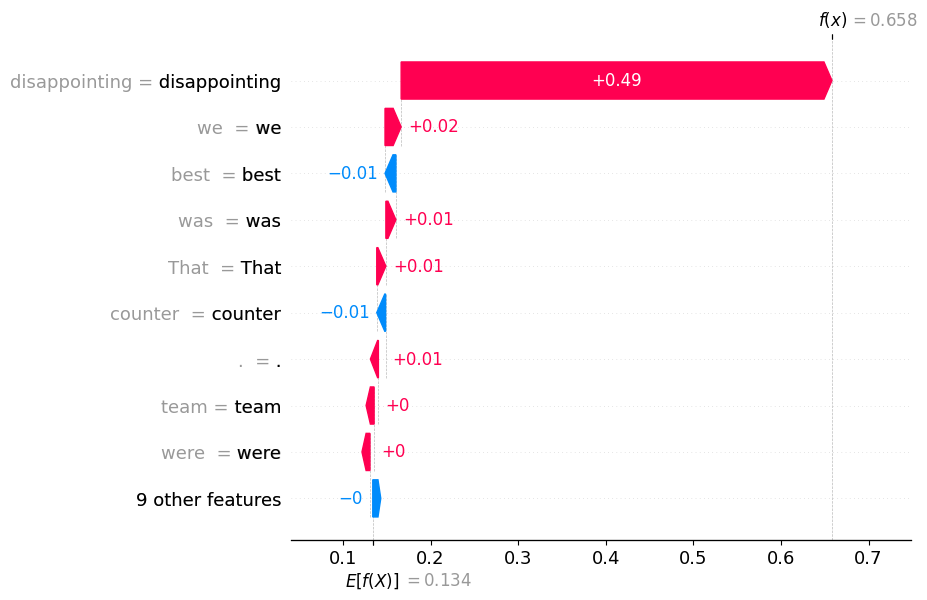

SHAP explanation for rank 2. disapproval: (p = 0.3968)


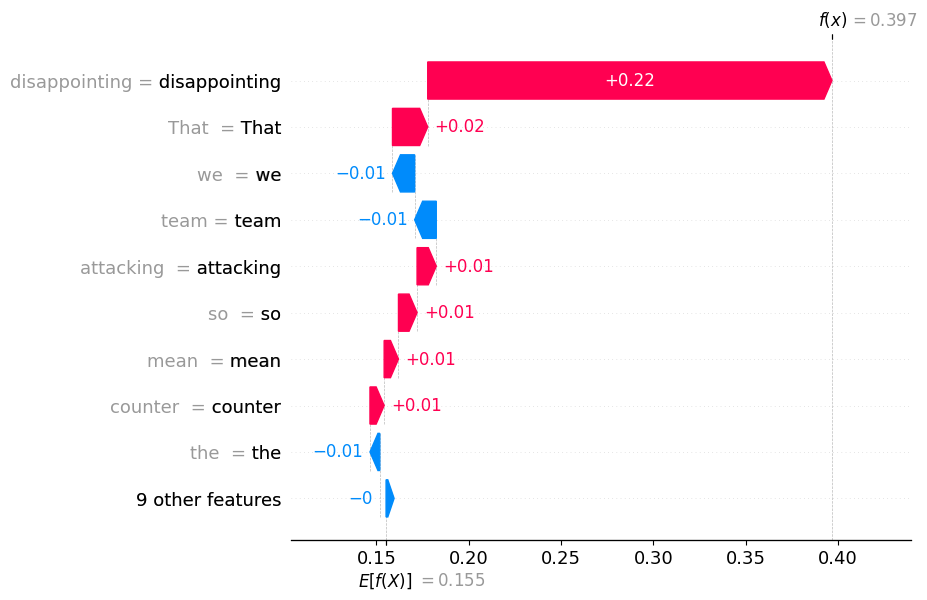

SHAP explanation for rank 3. admiration: (p = 0.3952)


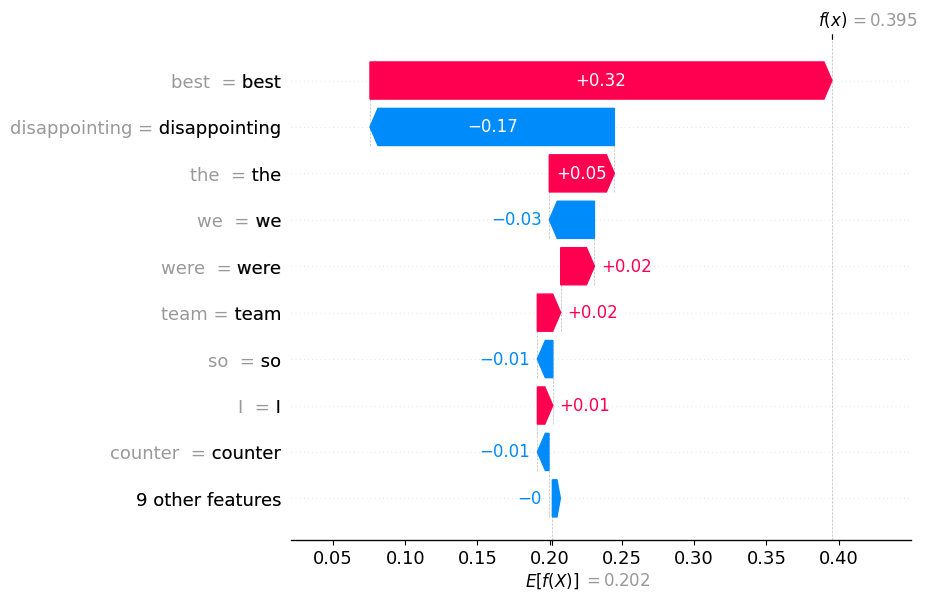

----------------------------------------------------------------------
Sample 3
Text: It was a terrible, terrible thing to do. He did every day of his time for it, has expressed regret, and has not repeated it.
Case type: Low-conf correct
Max prob: 0.46924665570259094
True labels: ['fear']
Predicted labels: ['fear']
Top 3 predicted emotions for this sample:
1. sadness: 0.4692
2. fear: 0.4536
3. remorse: 0.3865
SHAP explanation for rank 1. sadness: (p = 0.4692)


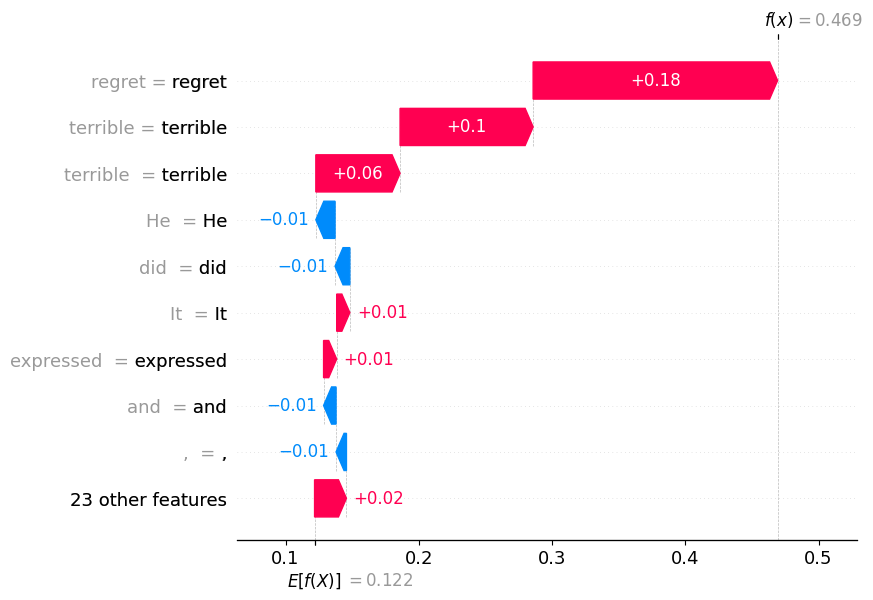

SHAP explanation for rank 2. fear: (p = 0.4536)


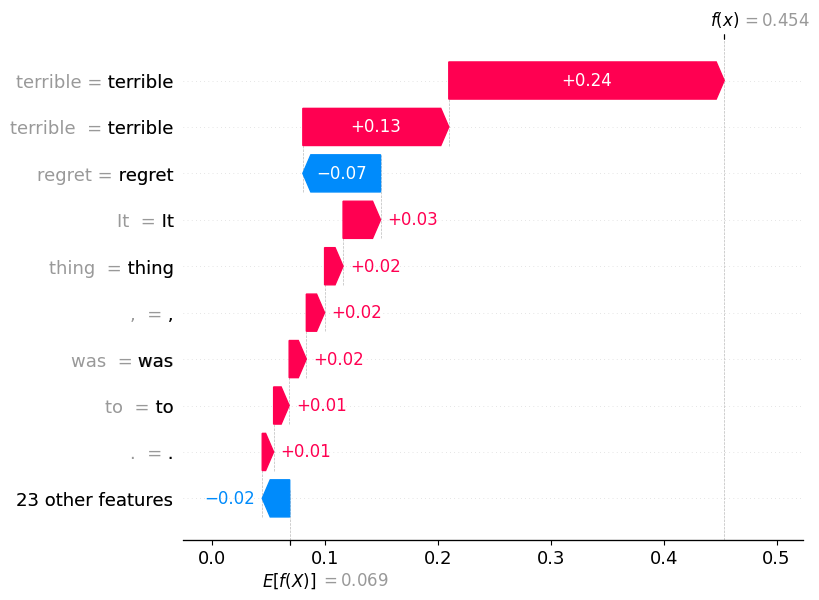

SHAP explanation for rank 3. remorse: (p = 0.3865)


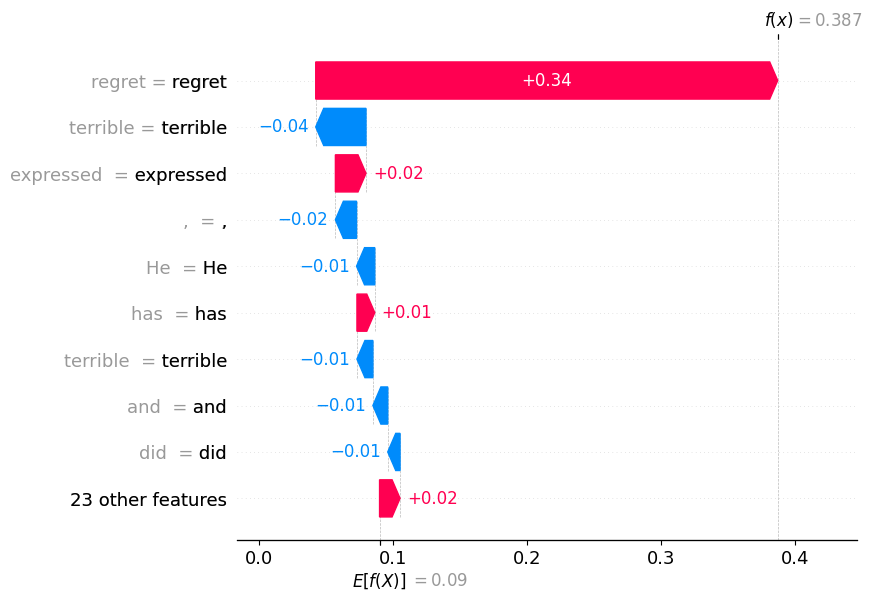

----------------------------------------------------------------------
Sample 4
Text: Don’t worry about it I meant what I said thank you really
Case type: High-conf correct
Max prob: 0.9402433633804321
True labels: ['gratitude']
Predicted labels: ['gratitude']
Top 3 predicted emotions for this sample:
1. gratitude: 0.9402
2. caring: 0.3215
3. approval: 0.2790
SHAP explanation for rank 1. gratitude: (p = 0.9402)


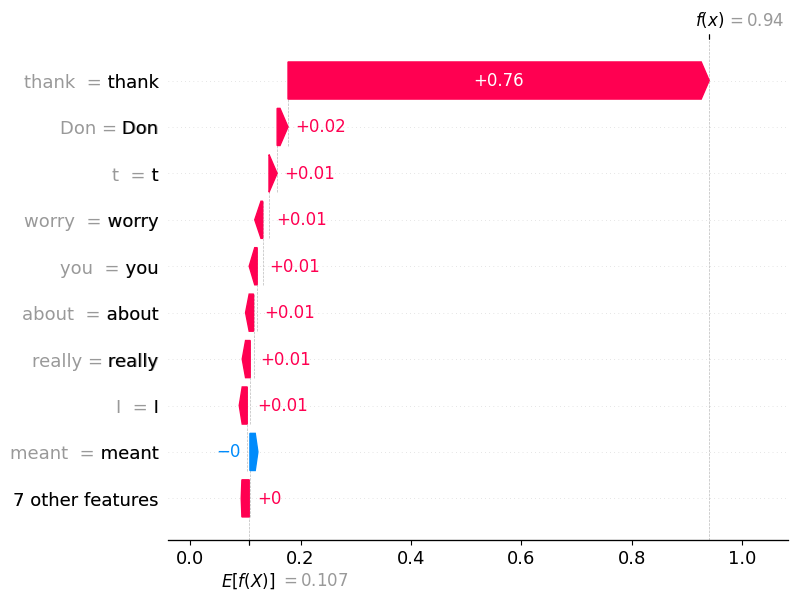

SHAP explanation for rank 2. caring: (p = 0.3215)


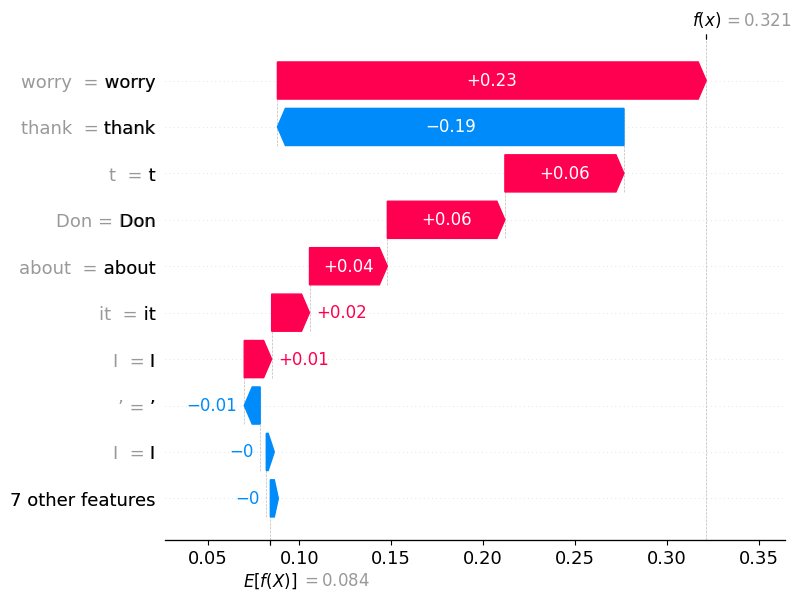

SHAP explanation for rank 3. approval: (p = 0.2790)


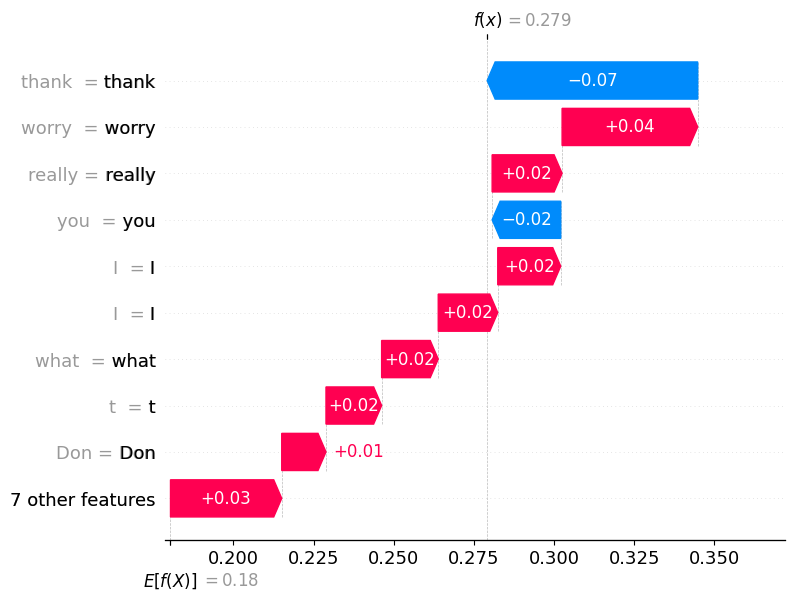

----------------------------------------------------------------------


In [29]:
#compute SHAP values and predicted probabilities for the selected texts
shap_values=explainer_shap(text_list_for_shap)
probs_all=predicted_prob(text_list_for_shap)

#iterate over each selected sample
for i, (idx, row) in enumerate(selected_inter_df.iterrows()):

  #extract and print basic info of the current sample
  text=row["text"]
  case_type=row["case_type"]
  max_prob=row["max_prob"]
  true_labels=row["true_labels"]
  pred_labels=row["pred_labels"]

  print(f"Sample {i}")
  print(f"Text:", text)
  print(f"Case type:", case_type)
  print(f"Max prob:", max_prob)
  print(f"True labels:", true_labels)
  print(f"Predicted labels:", pred_labels)

  #identify top 3 predicted emotions by probability
  probs_i=probs_all[i]
  top3_emos=probs_i.argsort()[-3:][::-1]

  print("Top 3 predicted emotions for this sample:")
  for rank, k in enumerate(top3_emos, start=1):
    label=label_names[k]
    prob=probs_i[k]
    print(f"{rank}. {label}: {prob:.4f}")

  #generate SHAP waterfall plots explaining each top-ranked emotion prediction
  for rank, k in enumerate(top3_emos, start=1):
    label=label_names[k]
    prob=probs_i[k]
    print(f"SHAP explanation for rank {rank}. {label}: (p = {prob:.4f})")
    shap.plots.waterfall(shap_values[i, :, k], max_display=10)

  print("-"*70)

##6.4.LIME-Based Explanations

In [30]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1cc26de86006129683e5d9b3a65a358885fd8041b83491d8ee5e08d64e3c52cb
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [31]:
from lime.lime_text import LimeTextExplainer

#create a LIME text explainer for multi-label classification
explainer_lime=LimeTextExplainer(class_names=label_names)

In [32]:
#iterate over each selected interpretability sample
for i, (idx, row) in enumerate(selected_inter_df.iterrows()):

  #extract and print basic info about the current sample
  text=row["text"]
  case_type=row["case_type"]
  max_prob=row["max_prob"]
  true_labels=row["true_labels"]
  pred_labels=row["pred_labels"]

  print(f"Sample {i}")
  print(f"Text:", text)
  print(f"Case type:", case_type)
  print(f"Max prob:", max_prob)
  print(f"True labels:", true_labels)
  print(f"Predicted labels:", pred_labels)

  #identify top 3 predicted emotions by probability
  probs_i=probs_all[i]
  top3_emos=probs_i.argsort()[-3:][::-1]

  print("Top 3 predicted emotions for this sample:")
  for rank, k in enumerate(top3_emos, start=1):
    label=label_names[k]
    prob=probs_i[k]
    print(f"{rank}. {label}: {prob:.4f}")

  #generate LIME explanation for the top 3 emotions
  exp=explainer_lime.explain_instance(text_instance=text, classifier_fn=predicted_prob, labels=list(top3_emos), num_features=10)

  #plot LIME explanation for each top emotion
  for rank, k in enumerate(top3_emos, start=1):
    label=label_names[k]
    prob=probs_i[k]
    print(f"LIME explanation for rank {rank}: {label} (p = {prob:.4f})")
    exp.show_in_notebook(text=True, labels=[k])
    print("_"*70)

Output hidden; open in https://colab.research.google.com to view.

## 6.5.Error Analysis of Misclassified Samples


For error analysis, 20 samples was selected, comprising incorrect predictions across four categories: high-confidence (≥0.8), medium-confidence (0.5–0.8), low-confidence (<0.5), and complex multi-label cases. Five samples were drawn from each category to ensure balanced coverage of different error types.

In [33]:
#select misclassified samples for error analysis, stratified by confidence levels and label complexity
def select_samples_err(
    df,
    num_high_conf_incorr=1,
    num_med_conf_incorr=1,
    num_low_conf_incorr=1,
    num_complex_incorr=1):

  #fixed random seed for reproducible sampling
  rnd_seed=np.random.RandomState(42)
  selected_texts_err=[]

  #high confidence (>=0.8) incorrect predictions
  high_conf_incorr=df[(~df["exact_match"]) & (df["max_prob"]>=0.8)]
  if len(high_conf_incorr)>0:
    selected_texts_err+=list(high_conf_incorr.sample(
        n=min(num_high_conf_incorr, len(high_conf_incorr)), random_state=rnd_seed
    ).index)

  #medicum confidence (50%-80%) incorrect predictions
  med_conf_incorr=df[(~df["exact_match"]) & (df["max_prob"]>=0.5) & (df["max_prob"]<0.8)]
  if len(med_conf_incorr)>0:
    selected_texts_err+=list(med_conf_incorr.sample(
        n=min(num_med_conf_incorr, len(med_conf_incorr)), random_state=rnd_seed
    ).index)

  #low confidence (<50%) incorrect predictions
  low_conf_incorr=df[(~df["exact_match"]) & (df["max_prob"]<0.5)]
  if len(low_conf_incorr)>0:
    selected_texts_err+=list(low_conf_incorr.sample(
        n=min(num_low_conf_incorr, len(low_conf_incorr)), random_state=rnd_seed
    ).index)

  #multi labeled text incorrect prediction (true_count>2 or pred_count>2)
  complex_incorr=df[(~df["exact_match"]) & ((df["true_count"]>2) | (df["pred_count"]>2))]
  if len(complex_incorr)>0:
    selected_texts_err+=list(complex_incorr.sample(
        n=min(num_complex_incorr, len(complex_incorr)), random_state=rnd_seed
    ).index)

  #remove duplicate texts in selected texts
  selected_texts_err=list(set(selected_texts_err))
  return selected_texts_err

In [34]:
#extract selected error analysis samples from the test set
selected_indices_err=select_samples_err(df_test,5, 5, 5, 5)
selected_texts_err=df_test.loc[selected_indices_err].copy()

In [35]:
#convert true and predicted binary label vectors to readable label names
selected_texts_err["true_labels"]=selected_texts_err["y_true"].apply(lambda v: vec_labels(v, label_names))
selected_texts_err["pred_labels"]=selected_texts_err["y_pred"].apply(lambda v: vec_labels(v, label_names))

#assign each sample by its confidence-correctness case labels for reporting
selected_texts_err["case_type"] = selected_texts_err.apply(tag_case, axis=1)

#flage multi_label cases
selected_texts_err["complex_case"] = (selected_texts_err["true_count"] > 2) | (selected_texts_err["pred_count"] > 2)


In [36]:
#display the error-analysis dataframe with decoded labels and case types
selected_texts_err

,text,y_true,y_pred,y_prob,exact_match,true_count,pred_count,max_prob,true_labels,pred_labels,case_type,complex_case
5377,Waiting for both of these things is torture,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.23057307, 0.08834723, 0.29098088, 0.4558041...",False,1,1,0.492192,[neutral],[annoyance],Low-conf incorrect,False
785,30 bombs won’t be enough for me to feel good r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.38398772, 0.15947904, 0.14294825, 0.2756168...",False,1,0,0.475088,[neutral],[],Low-conf incorrect,False
4891,Oof the way he just tossed the cat aside oof,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.24006125, 0.17147702, 0.31017178, 0.4138324...",False,1,1,0.734120,[surprise],[neutral],Med-conf incorrect,False
2721,"<NAME> is a warmonger. Other than that, he’s p...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.68320817, 0.10989668, 0.13206615, 0.2107662...",False,1,3,0.683208,[admiration],"[admiration, approval, neutral]",Med-conf incorrect,True
1445,im done with my break im going to make more i ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.22286923, 0.09073549, 0.27973008, 0.3080861...",False,1,1,0.488771,[neutral],[approval],Low-conf incorrect,False
424,Yes! My Big Fat Fabulous Life,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.691289, 0.2104416, 0.12220858, 0.15687834, ...",False,1,3,0.691289,[admiration],"[admiration, excitement, joy]",Med-conf incorrect,True
4530,Where can I get some? These are awesome!,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8130158, 0.14878775, 0.12147716, 0.15520649...",False,1,1,0.813016,[curiosity],[admiration],High-conf incorrect,False
3378,"I gotchu bro, house By Gucci Mane I’m a huge G...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4960481, 0.20024471, 0.14104462, 0.23388131...",False,3,2,0.514797,"[approval, excitement, joy]","[approval, neutral]",Med-conf incorrect,True
3257,To much of a good thing is a bad thing,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.23775287, 0.1377643, 0.19329959, 0.32949957...",False,1,1,0.556400,[approval],[disapproval],Med-conf incorrect,False
3779,Congrats!!! Happy for you.,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.61398906, 0.20561504, 0.13488984, 0.1283065...",False,1,3,0.731634,[joy],"[admiration, gratitude, joy]",Med-conf incorrect,True


# 7.Saving Final Model and Metadata for Prototype Deployment


In [37]:
#save final model, tokenizer and metadata for deployment in Streamlit prototype
import json, os

#define directory for storing the final model artefacts
best_model_dir="/content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype/best_emo_model"

#create directory if it does not exist
os.makedirs(best_model_dir, exist_ok=True)

model_final.save_pretrained(best_model_dir) #save final fine-tuned transformer model
tokenizer.save_pretrained(best_model_dir)   #save tokenizer used during training and inference

emo_thresholds=overall_best["thresholds"]   #retrieve validation-optimised per-label optimal thresholds
emotion_labels=label_names

#build metadata dictionary for inference
meta_data={
    "model_name":best_model_name,
    "max_len":max_len,
    "emotion_labels":emotion_labels,
    "emo_thresholds":emo_thresholds.tolist(),
    "categories":categories,
    "emo_to_cat":emo_to_cat,
    "aggregation":"noisy_or",
    "cat_thresholds":ts_cat.tolist()
}

#write metadata to JSON file inside the saved directory
with open(os.path.join(best_model_dir, "meta_data.json"), "w") as f:
  json.dump(meta_data, f)

print("Model, tokenizer and meta data saved sucessfully to", best_model_dir)

Model, tokenizer and meta data saved sucessfully to /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype/best_emo_model
